## Correlation Analysis

In this section, we take a look at two methods to calculate correlations. Below are the packages used for these excercises.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import itertools
from matplotlib import pyplot as plt

### Simple Correlation
First, we need to load in our dataset for calculating the correlation between variables.

In [4]:
df = pd.read_csv('combined.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23735 entries, 0 to 23734
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            23735 non-null  int64  
 1   ACCIDENTDATE          23735 non-null  object 
 2   AOTACTUALMILEPOINT    23735 non-null  float64
 3   AOTROUTE              23735 non-null  object 
 4   Animal                23735 non-null  object 
 5   CITYORTOWN            23735 non-null  object 
 6   DIROFCOLLI            23735 non-null  object 
 7   DayNight              23735 non-null  object 
 8   HOWMAPPED             23735 non-null  object 
 9   INTERSECTIONWITH      23735 non-null  object 
 10  Impairment            23735 non-null  object 
 11  InjuryType            23735 non-null  object 
 12  Involving             23735 non-null  object 
 13  LAT_DD                23735 non-null  float64
 14  LOCALID               23735 non-null  object 
 15  LOC_ERROR          

Next, we will calculate the correlation using the .corr() method

Text(0.5, 1, 'Basic Correlation')

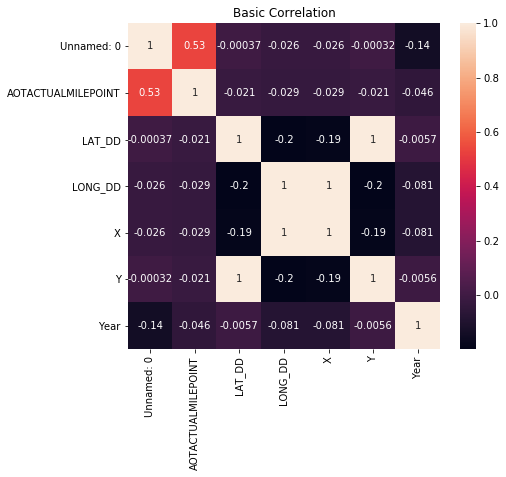

In [8]:
correlation = df.corr()

'''ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)'''

fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(correlation, annot=True, ax=ax) 
ax.set_title("Basic Correlation")

As you can see, the function worked, however only on the numeric data we have in our dataset. This data used in the correlation analysis used variables such as year, latitude, and longitude. 
As they're only useful to us as identifiers, this analysis isn't useful. Although, it does help us confirm that X is the same as Latitude, and Y is the same as Longitude

### Cramer's V Correlation
In researching potential correlation calculations for our dataset, which mainly is composed of categorical data, we discovered an algorithm that computes correlation on categorical variables.
Note that the following code is taken from a research paper and cited within the following function.

The first step is to chose which columns from the dataset we would like to calculate. We chose every column that was of type "object", and then further reduced the columns to eliminate redundancy.

In [22]:
# We need to choose columns to correlate
chosen_cols = ['Animal','CITYORTOWN','DIROFCOLLI','DayNight',
                 'Impairment', 'InjuryType','Involving','LOCALID','RoadCharacteristics','SurfaceCondition',
                 'Weather','INTERSECTIONWITH']

Next, we define the function used for the calculation of the correlations.

In [14]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

The third step is to run the calculations and save them into a correlation matrix. The try/except statements are there to handle a specific error that occurs within our data. The crosstabulation for a few combinations of variables is much too large to compute, so we utilize an except statement to replace those values with 0. There might be a small correlation, but without further reduction of one of the variables we cannot tell. We chose not to reduce the troubling variable, INTERSECTIONWITH, to ensure that the quality of data remains as high as possible.

In [16]:
# Code taken from https://www.kaggle.com/phaethonprime/eda-and-logistic-regression
# Adjusted to fit our dataset
corr_matrix = np.zeros((len(chosen_cols),len(chosen_cols)))

for col1, col2 in itertools.combinations(chosen_cols, 2):
    try:
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]
    except:
        # If an error is thrown, replace the correlation value with 0.00
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = 0.00
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

The final step is to plot the correlation using a heatmap.

Text(0.5, 1, 'Cramer V Correlation')

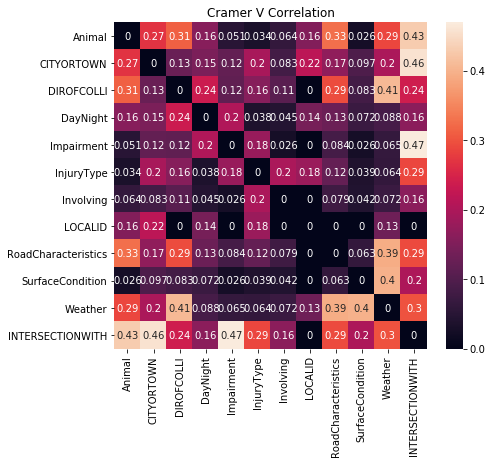

In [17]:
corr = pd.DataFrame(corr_matrix, index=chosen_cols, columns=chosen_cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Cramer V Correlation")

As the above plot shows us, there are not many strong correlations. Some of the stronger correlations makes sense - INTERSECTIONWITH names roads that exist within CITYORTOWN - but some of them are still interesting.

At a high level, INTERSECTIONWITH and Animal only have a correlation of .43, but this suggests that there are particular intersections that have more animal related car crashes.
Similarily, INTERSECTIONWITH and Impairment also have a slightly stronger correlation, which suggests that there are hotspots of alchol use.
The story gets more interesting when we look at DIROFCOLLI and Weather. Why would weather determine the direction of collision? Let's explore this relationship.

In [25]:
# Crosstab of DIROFCOLLI and Weather
pd.crosstab(df['DIROFCOLLI'],df['Weather'])

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Unknown,Wind
DIROFCOLLI,,,,,,
Head On,410,146,183,55,32,5
"Left Turn and Thru, Angle Broadside -->v--",432,137,41,48,21,0
"Left Turn and Thru, Broadside v<--",205,67,27,25,10,1
"Left Turn and Thru, Head On ^v--",70,25,6,6,3,0
"Left Turn and Thru, Same Direction Sideswipe/Angle Crash vv--",83,35,9,6,3,0
"Left Turns, Opposite Directions, Head On/Angle Crash --^v--",18,6,0,4,0,0
"Left Turns, Same Direciton, Rear End v--v--",9,2,1,2,0,0
"Left Turns, Same Direction, Rear End v--v--",11,4,2,1,0,0
"Left and Right Turns, Simultaneous Turn Crash --vv--",24,7,4,3,1,0


We need to clean the DIROFCOLLI column a little more. We will remove unknowns and group the values together, generate a new confusion matrix, then recalculate Cramer's V.

In [8]:
# Removing Unknowns from data
df2 = df
df2 = df2[df.DIROFCOLLI != 'Unknown']
df2 = df2[df.Weather != 'Unknown']

# Grouping values in DIROFCOLLI
# Create groups of values
b_list = ['Left Turn and Thru, Angle Broadside -->v--','Left Turn and Thru, Broadside v<--', 
          'No Turns, Thru moves only, Broadside ^<', 'Right Turn and Thru, Angle Broadside -->^--', 
          'Right Turn and Thru, Broadside ^<--']
h_list = ['Left Turn and Thru, Head On ^v--', 'Left Turns, Opposite Directions, Head On/Angle Crash --^v--', 'Right Turn and Thru, Head On v^--']
s_list = ['Left Turn and Thru, Same Direction Sideswipe/Angle Crash vv--','Left and Right Turns, Simultaneous Turn Crash --vv--', 
          'Opp Direction Sideswipe','Right Turn and Thru, Same Direction Sideswipe/Angle Crash ^^--','Same Direction Sideswipe']
r_list = ['Left Turns, Same Direction, Rear End v--v--','Left Turns, Same Direciton, Rear End v--v--','Rear-to-rear','Right Turn, Same Direciton, Rear End ^--^--',
          'Right Turn, Same Direction, Rear End ^--^--']
            
# Loop through column and replace values
for i in b_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Broadside')
for i in h_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Head On')
for i in s_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Sideswipe')
for i in r_list:
    df2['DIROFCOLLI'] = df2['DIROFCOLLI'].replace(i, 'Rear End')

g:\python\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [81]:
#  New Crosstab of DIROFCOLLI and Weather
new_crosstab = pd.crosstab(df2['DIROFCOLLI'],df2['Weather'])
new_crosstab

Weather,Clear,Cloudy,Freezing Precipitation,Rain,Wind
DIROFCOLLI,,,,,
Broadside,1476,499,232,178,5
Head On,508,179,194,66,5
Other - Explain in Narrative,1082,397,211,124,4
Rear End,2570,916,365,278,7
Sideswipe,1440,520,298,166,4
Single Vehicle Crash,2507,1144,1127,473,24


In [83]:
cramers_corrected_stat(new_crosstab)

0.08426088203317546

As you can see, the correlation of 41% was misleading. The actual value is closer to **8%**. The unknowns available in the original data were skewing the calculation, so there really isn't a correlation there. Since we can see how misleading this correlation is, lets look at the relationship between INTERSECTIONWITH and the other variables with greater than 40% correlation.

In [6]:
pd.crosstab(df['INTERSECTIONWITH'],df['Animal'])

Animal,Deer,Domestic,Moose,None/Other,Unknown,Wild
INTERSECTIONWITH,,,,,,
Leicester Whiting Rd,0,0,0,1,0,0
"""Truly Unique""",0,0,0,1,0,0
"""Twin Bridges"", Bridge Over Rt 4a Whipple Hollow Rd",0,0,0,1,0,0
# 1047 US Rte. 302,0,0,0,1,0,0
# 135,0,0,0,1,0,0
...,...,...,...,...,...,...
church St,0,0,0,3,0,0
la Perle Dr,0,0,1,0,0,0
s Winooski Ave,0,0,0,1,0,0


The crosstab shows a lot of values for INTERSECTIONWTIH, but we want to keep as many values as possible so we are going to reduce the animal column and then recalculate 

In [15]:
# Grouping values in DIROFCOLLI
# Create groups of values
a_list = ['Animal','Deer','Domestic','Moose','Unknown','Wild']
            
# Loop through column and replace values
for i in a_list:
    df2['Animal'] = df2['Animal'].replace(i, 'Animal Hit')

df2['Animal'] = df2['Animal'].replace('None/Other','No Animal Hit')

intersection_animal = pd.crosstab(df2['INTERSECTIONWITH'],df2['Animal'])


cramers_corrected_stat(intersection_animal)

0.290114800515371

The correlation lowered a bit but still suggests that there is a small correlation between these variables. We will repeat the process one more time to check INTERSECTIONWITH and Impairment

In [18]:
# Grouping values in DIROFCOLLI
# Create groups of values
i_list = ['Alcohol','Alcohol and Drugs','Drugs']
            
# Loop through column and replace values
for i in i_list:
    df2['Impairment'] = df2['Impairment'].replace(i, 'Impaired')

df2['Impairment'] = df2['Impairment'].replace('None','Not Impaired')

intersection_impairment= pd.crosstab(df2['INTERSECTIONWITH'],df2['Impairment'])


cramers_corrected_stat(intersection_impairment)

0.28900974993127704

This had the same effect as the previous correlation. Let's revisualize the correlation chart again.

Text(0.5, 1, 'Final Cramer V Correlation')

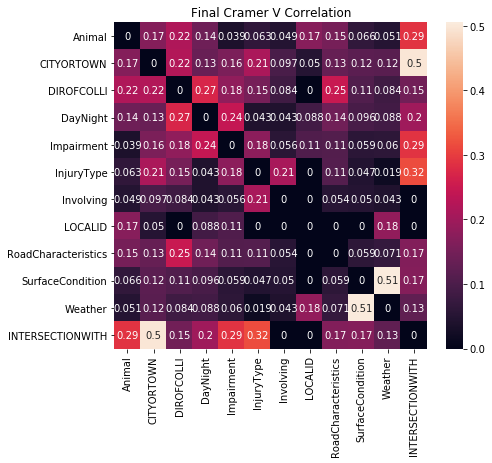

In [25]:
corr_matrix = np.zeros((len(chosen_cols),len(chosen_cols)))

for col1, col2 in itertools.combinations(chosen_cols, 2):
    try:
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df2[col1], df2[col2]))
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]
    except:
        # If an error is thrown, replace the correlation value with 0.00
        idx1, idx2 = chosen_cols.index(col1), chosen_cols.index(col2)
        corr_matrix[idx1, idx2] = 0.00
        corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

        
corr = pd.DataFrame(corr_matrix, index=chosen_cols, columns=chosen_cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Final Cramer V Correlation")

Interestingly, after cleaning the data some more, we see a stronger correlation between weather and surface condition. This is a relationship we assumed would be visible, as the weather determines if a road is icy or wet for the most part.